# MAPD mod. B - Final Project
##  Streaming processing of cosmic rays using Drift Tubes detectors

The goal of this project is to reproduce a real-time processing of real data collected in a particle physics detector and publish the results in a
dashboard for live monitoring.

### Students:
    - Aidin Attar - 2048654
    - Ema Baci - 2050726
    - Mariam Hergnyan - 2040478

## Consumer

In [34]:
import json
import pylab as pl
import numpy as np

from IPython import display

from kafka import KafkaConsumer
from kafka.admin import KafkaAdminClient

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import json
import pylab as pl
import numpy as np
from matplotlib.gridspec import GridSpec

In [35]:
#KAFKA_HOME = '/root/kafka_2.13-3.2.1'
# kafka server
KAFKA_BOOTSTRAP_SERVERS = ['pd-slave3:9092',]

# definition of the consumer
consumer = KafkaConsumer(bootstrap_servers=KAFKA_BOOTSTRAP_SERVERS, consumer_timeout_ms=100000)
consumer.topics()

{'topic_results', 'topic_stream'}

In [36]:
consumer.subscribe('topic_results')
consumer.subscription()

{'topic_results'}

In [37]:
# print the list of partition IDs 
# e.g. a topic with tree partitions will have partition IDs {0, 1, 2}
consumer.partitions_for_topic('topic_results')

{0}

### Histogram Plotting

In [47]:
def set_axes( ax, ax1, set_lims='single' ):
    if set_lims == 'single':
        ax[0,0].set_xlim([ 0,  63])
        ax[0,1].set_xlim([64, 127])
        ax[0,2].set_xlim([ 0,  63])
        ax[0,3].set_xlim([64, 127])
        ax[0,0].set_ylim([ 0, 100])
        ax[0,1].set_ylim([ 0, 100])
        ax[0,2].set_ylim([ 0, 100])
        ax[0,3].set_ylim([ 0, 100])

        ax[1,0].set_xlim([0,  15])
        ax[1,1].set_xlim([0,  15])
        ax[1,2].set_xlim([0,  15])
        ax[1,3].set_xlim([0,  15])
        ax[1,0].set_ylim([0, 750])
        ax[1,1].set_ylim([0, 750])
        ax[1,2].set_ylim([0, 750])
        ax[1,3].set_ylim([0, 750])

        ax[2,0].set_xlim([ 0, 63])
        ax[2,1].set_xlim([64,127])
        ax[2,2].set_xlim([ 0, 63])
        ax[2,3].set_xlim([64,127])
        ax[2,0].set_ylim([0,   3])
        ax[2,1].set_ylim([0,   3])
        ax[2,2].set_ylim([0,   3])
        ax[2,3].set_ylim([0,   3])

    elif set_lims == 'cumulative':
        ax[0,0].set_xlim([ 0,  63])
        ax[0,1].set_xlim([64, 127])
        ax[0,2].set_xlim([ 0,  63])
        ax[0,3].set_xlim([64, 127])
        ax[1,0].set_xlim([0,  15])
        ax[1,1].set_xlim([0,  15])
        ax[1,2].set_xlim([0,  15])
        ax[1,3].set_xlim([0,  15])
        ax[2,0].set_xlim([ 0, 63])
        ax[2,1].set_xlim([64,127])
        ax[2,2].set_xlim([ 0, 63])
        ax[2,3].set_xlim([64,127])
    
def time( histo_prev, histo_new, n ):
    '''
    Times per batch
    '''
    histo_prev[    'time'].append(histo_new[    'time'])
    histo_prev['epoch_id'].append(histo_new['epoch_id'])
    
    while( len(histo_prev['time']) > n ):
        histo_prev[    'time'].pop(0)
        histo_prev['epoch_id'].pop(0)
            
    return histo_prev


    
def hist_sum( histo_prev, histo_new ):
    '''
    Function to update the histogram with the new values,
    obtaining the cumulative values.
    Inputs:
        histo_prev: message with the previous sum
        histo_new: message with the new values
    Output:
        message with the updated values
    '''
    histo_prev[    'time'] = histo_prev[    'time'] + histo_new[    'time']
    histo_prev['epoch_id'] =                          histo_new['epoch_id']
    histo_prev[    'hits'] = histo_prev[    'hits'] + histo_new[    'hits']
    
    for chamber in ['CH0','CH1','CH2','CH3']:
        histo_prev[chamber]['total_hits'] = histo_prev[chamber]['total_hits'] + histo_new[chamber]['total_hits']
        for feature in ['histo_CH', 'histo_ORB', 'histo_SC']:
            new_edges = np.array(list(map(int, histo_new[chamber][feature]['bin_edges'])))
            histo_prev[chamber][feature][ 'bin_counts'][new_edges] = histo_prev[chamber][feature][ 'bin_counts'][new_edges] + \
                                                                     histo_new[ chamber][feature][ 'bin_counts']
    return histo_prev

def build_hist( msg, start, fig, axes, ax_time, set_lims='single' ):
    '''
    Function to build up the histograms in the 
    live dashboard.
    Inputs:
        - msg: message content
        - fig: matplotlib figure
        - axes: list of axes of the figure
        - set_lims: bool, true if single batch histograms are plotted
    '''
    labels     = [ 'TDC_CHANNEL', 'ORBIT_CNT', 'TDC_CHANNEL']
    histograms = [    'histo_CH', 'histo_ORB',    'histo_SC' ]
    
    for i, AX in enumerate(axes): # loop over chambers
        if (i < 3):
            histo = histograms[i]

            for j, ax in enumerate(AX): # loop over histograms
                chamber = 'CH'+str(j)
                ax.clear()
                ax.grid(ls='dotted')
                ax.set_title( chamber )
                ax.set_xlabel(labels[i])
                ax.bar( list(map(int, msg[chamber][histo][ 'bin_edges'])),
                                  msg[chamber][histo]['bin_counts'] )
                ax.tick_params()
        if (i == 3):

            ax_time.clear()
            ax_time.grid(ls='dotted', )
            n = 30
            val = time(start, msg, n )
            ax_time.scatter(val['epoch_id'], val['time'])
            ax_time.set_xlabel('epoch_id')
            ax_time.set_ylabel('time (s)')
            
    set_axes(axes, ax_time, set_lims)
    display.clear_output(wait=True)
    display.display(pl.gcf())


### Single Batch Dashboard


KeyboardInterrupt



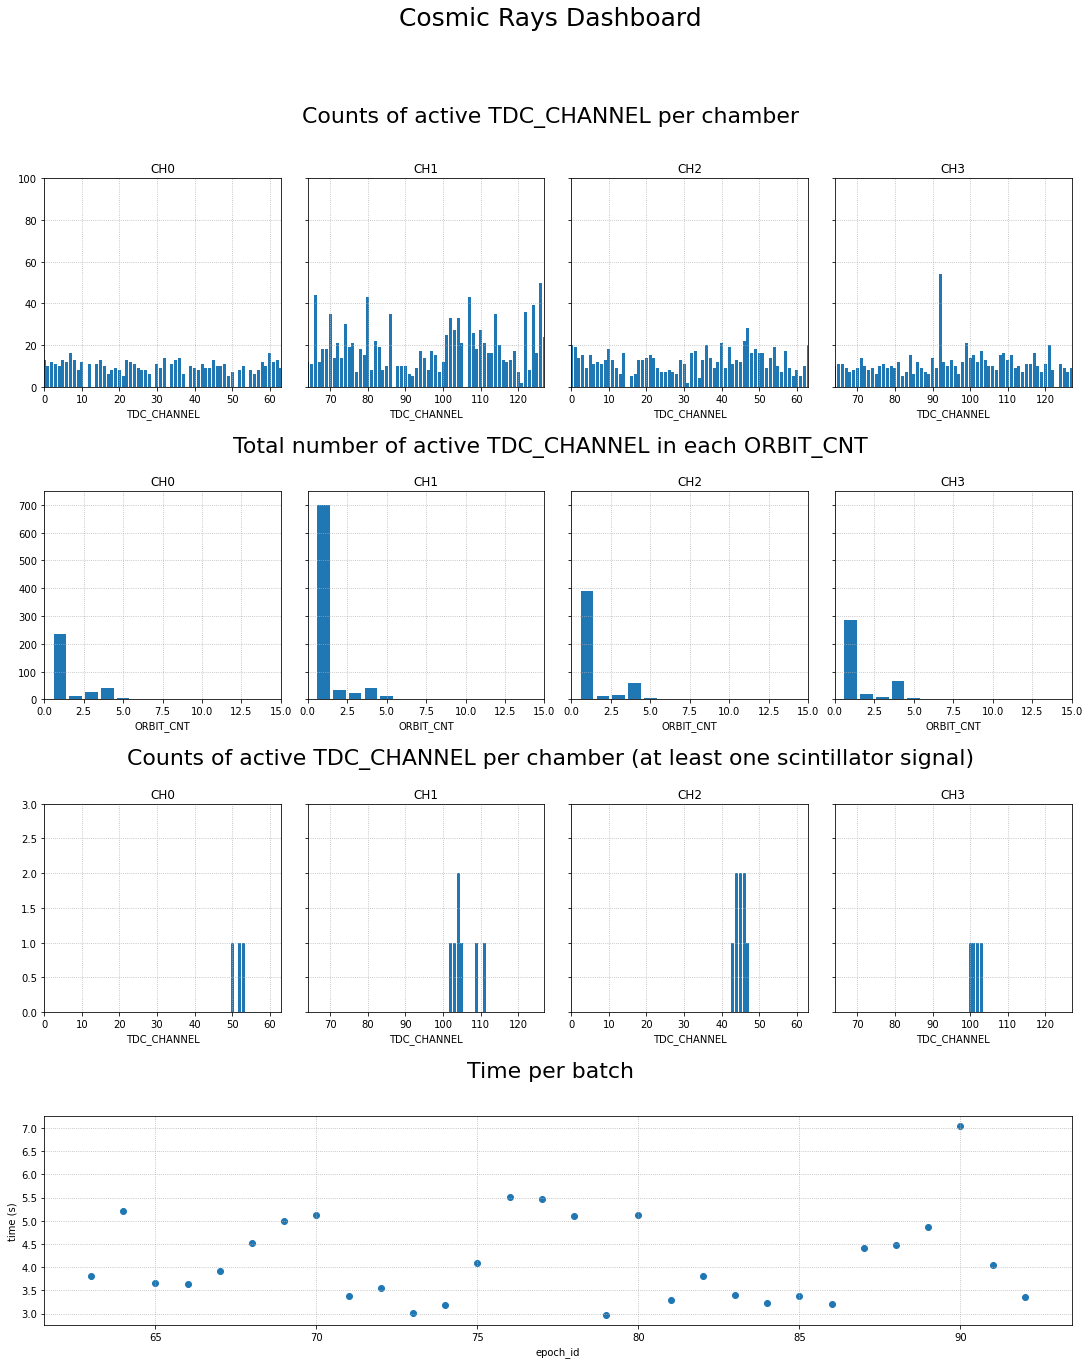

In [48]:
fig, ax = plt.subplots(nrows=4, ncols=4, sharey='row', figsize=(15,17))
for ax_ in ax[3,: ]:
        ax_.remove()

gs = GridSpec(4, 4, figure=fig, )
ax1 = fig.add_subplot(gs[3, :])
ax1.tick_params(labelbottom=True, labelleft=True)
ax1.set_autoscale_on(False)

fig.suptitle('Cosmic Rays Dashboard', fontsize=25, y=1.1)
fig.tight_layout()
fig.subplots_adjust(hspace=.5)

plt.figtext(0.5, 1.01, 'Counts of active TDC_CHANNEL per chamber', ha='center', va='center', fontsize = 22)
plt.figtext(0.5,  .74, 'Total number of active TDC_CHANNEL in each ORBIT_CNT', ha='center', va='center', fontsize = 22)
plt.figtext(0.5, .485, 'Counts of active TDC_CHANNEL per chamber (at least one scintillator signal)', ha='center', va='center', fontsize = 22)
plt.figtext(0.5,  .23, 'Time per batch', ha='center', va='center', fontsize = 22)

start = {'epoch_id':[],'time':[] }

for msg in consumer:

    msg_json = json.loads(msg.value)
    
    print("Number of hits: ", msg_json['hits'])
    for chamber in range(4):
        print(f"Number of hits - CHAMBER {chamber}:\t", msg_json['CH'+str(chamber)]['total_hits'])
    
    build_hist(msg_json, start, fig, ax, ax1, 'single')


### Cumulative Dashboard


KeyboardInterrupt



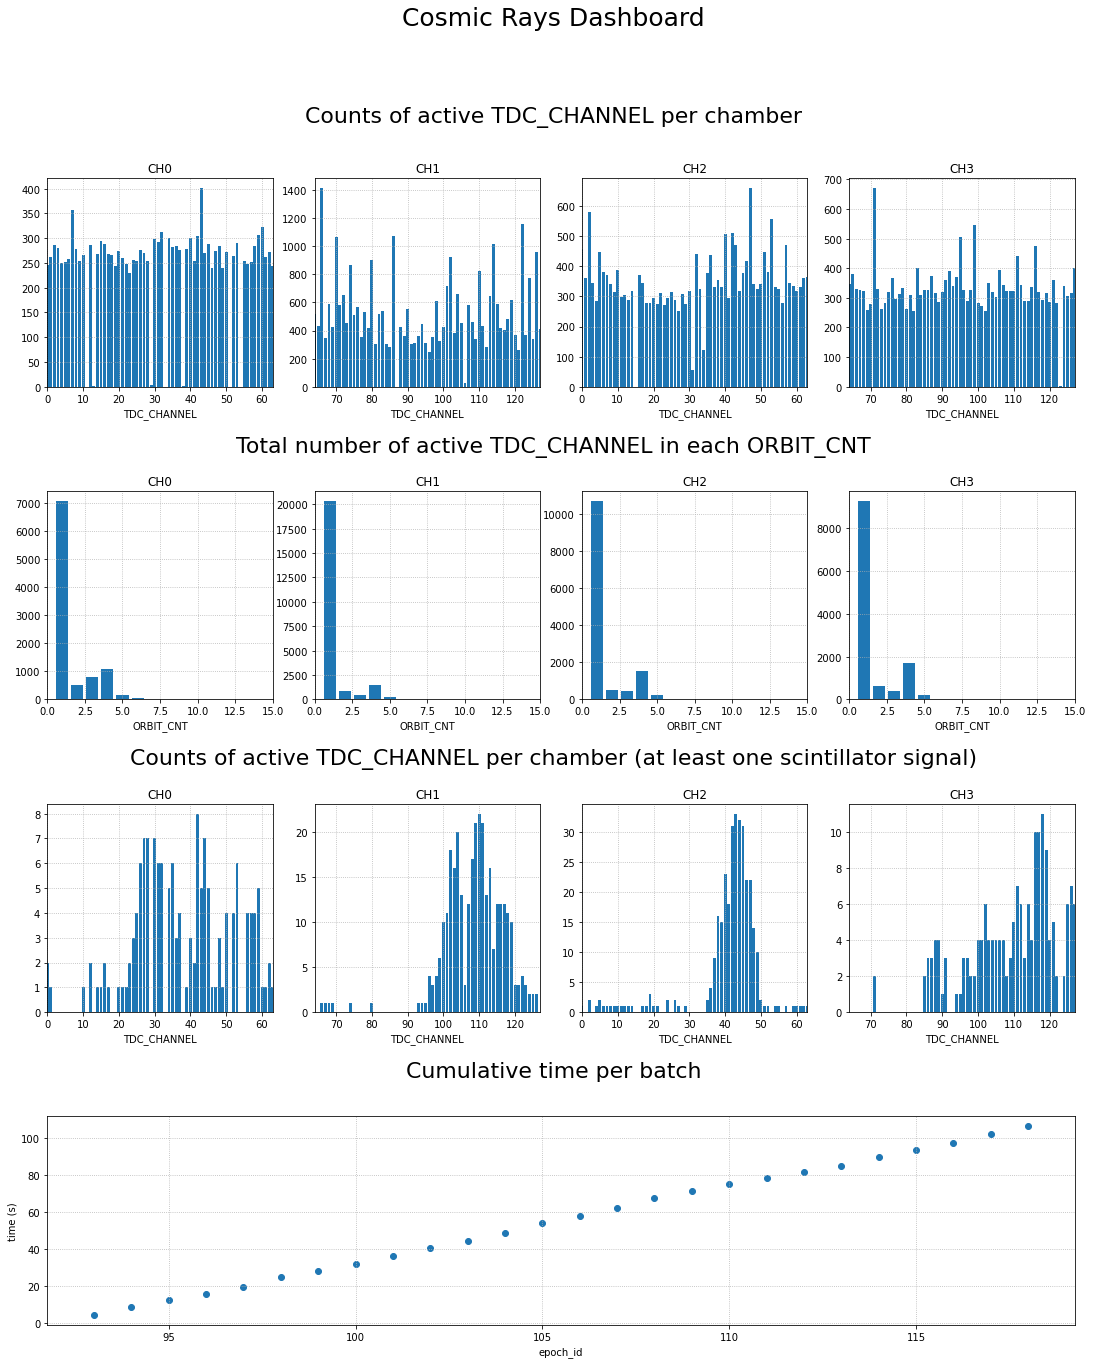

In [49]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(15,17))
for ax_ in ax[3,: ]:
        ax_.remove()

gs = GridSpec(4, 4, figure=fig, )
ax1 = fig.add_subplot(gs[3, :])
ax1.tick_params(labelbottom=True, labelleft=True)
ax1.set_autoscale_on(False)

fig.suptitle('Cosmic Rays Dashboard', fontsize=25, y=1.1)
fig.tight_layout()
fig.subplots_adjust(hspace=.5)

plt.figtext(0.5, 1.01, 'Counts of active TDC_CHANNEL per chamber', ha='center', va='center', fontsize = 22)
plt.figtext(0.5,  .74, 'Total number of active TDC_CHANNEL in each ORBIT_CNT', ha='center', va='center', fontsize = 22)
plt.figtext(0.5, .485, 'Counts of active TDC_CHANNEL per chamber (at least one scintillator signal)', ha='center', va='center', fontsize = 22)
plt.figtext(0.5,  .23, 'Cumulative time per batch', ha='center', va='center', fontsize = 22)

start = {'epoch_id':[],'time':[] }

for i, msg in enumerate(consumer):
    if i == 0:
        msg_json = json.loads(msg.value)

        for chamber in ['CH0','CH1','CH2','CH3']:
            for feature in ['histo_CH', 'histo_ORB', 'histo_SC']:
                edges  = np.arange(128)
                counts = np.zeros(shape=128, dtype=int)
                new_edges = np.array(list(map(int, msg_json[chamber][feature]['bin_edges'])))
                counts[new_edges] += msg_json[chamber][feature]['bin_counts']
                msg_json[chamber][feature][ 'bin_edges']         =  edges
                msg_json[chamber][feature]['bin_counts']         = counts
    else:
        msg_json = hist_sum(msg_json, json.loads(msg.value))

    print("Number of hits: ", msg_json['hits'])
    for chamber in range(4):
        print(f"Number of hits - CHAMBER {chamber}:\t", msg_json['CH'+str(chamber)]['total_hits'])
    
    build_hist(msg_json, start, fig, ax, ax1, 'cumulative')